# Yambda Dataset Analysis and Matrix Factorization

Loading the dataset, filtering listens, visualizing track popularity, and training a recommendation model.

![yambda](images/yambda.png)

Arxiv: https://arxiv.org/abs/2505.22238  
Hugging Face: https://huggingface.co/datasets/yandex/yambda

In [1]:
from typing import Literal
from datasets import Dataset, DatasetDict, load_dataset
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

# YambdaDataset wrapper class (https://huggingface.co/datasets/yandex/yambda)
class YambdaDataset:
    INTERACTIONS = frozenset([
        "likes", "listens", "multi_event", "dislikes", "unlikes", "undislikes"
    ])

    def __init__(
        self,
        dataset_type: Literal["flat", "sequential"] = "flat",
        dataset_size: Literal["50m", "500m", "5b"] = "50m"
    ):
        assert dataset_type in {"flat", "sequential"}
        assert dataset_size in {"50m", "500m", "5b"}
        self.dataset_type = dataset_type
        self.dataset_size = dataset_size

    def interaction(self, event_type: Literal[
        "likes", "listens", "multi_event", "dislikes", "unlikes", "undislikes"
    ]) -> Dataset:
        assert event_type in YambdaDataset.INTERACTIONS
        return self._download(f"{self.dataset_type}/{self.dataset_size}", event_type)

    def audio_embeddings(self) -> Dataset:
        return self._download("", "embeddings")

    def album_item_mapping(self) -> Dataset:
        return self._download("", "album_item_mapping")

    def artist_item_mapping(self) -> Dataset:
        return self._download("", "artist_item_mapping")

    @staticmethod
    def _download(data_dir: str, file: str) -> Dataset:
        data = load_dataset("yandex/yambda", data_dir=data_dir, data_files=f"{file}.parquet")
        # Returns DatasetDict; extracting the only split
        assert isinstance(data, DatasetDict)
        return data["train"]

## Data Loading

Download the smallest version of Yambda dataset (50M interactions) from Hugging Face.

In [2]:
# Load data using YambdaDataset
yambda = YambdaDataset(dataset_type="flat", dataset_size="50m")
ds = yambda.interaction("multi_event")  # load all events
print(f"Loaded {len(ds):,} records (multi_event)")

Loaded 47,790,449 records (multi_event)


In [3]:
# Load additional data: audio embeddings, album and artist mappings
print("Loading audio embeddings...")
# audio_embeddings = yambda.audio_embeddings()
# df_audio = pl.from_arrow(audio_embeddings.data.table)
# print(f"Audio embeddings: {len(df_audio):,} tracks")
# print("\n=== Audio Embeddings (head) ===")
# df_audio.head(5)

Loading audio embeddings...


In [4]:
print("Loading album-item mapping...")
album_mapping = yambda.album_item_mapping()
df_album = pl.from_arrow(album_mapping.data.table)
print(f"Album-item mapping: {len(df_album):,} rows")
print("\n=== Album-Item Mapping (head) ===")
df_album.head(5)

Loading album-item mapping...
Album-item mapping: 9,651,644 rows

=== Album-Item Mapping (head) ===


album_id,item_id
u32,u32
1,1491131
1,5109849
1,6735246
2,2859065
3,1859377


In [5]:
print("Loading artist-item mapping...")
artist_mapping = yambda.artist_item_mapping()
df_artist = pl.from_arrow(artist_mapping.data.table)
print(f"Artist-item mapping: {len(df_artist):,} rows")
print("\n=== Artist-Item Mapping (head) ===")
df_artist.head(5)

Loading artist-item mapping...
Artist-item mapping: 9,271,906 rows

=== Artist-Item Mapping (head) ===


artist_id,item_id
u32,u32
1,953587
1,1921481
1,2659068
1,2740764
1,6767564


In [6]:
df = pl.from_arrow(ds.data.table)

# Print all unique values for is_organic and event_type
unique_is_organic = df["is_organic"].unique().sort().to_list()
unique_event_type = df["event_type"].unique().sort().to_list()

print("=== Unique values ===")
print(f"is_organic: {unique_is_organic}")
print(f"event_type: {unique_event_type}")
print()

# Filter only listen events
df_listens = (
    df.filter(pl.col("event_type") == "listen")
    .select(["uid", "timestamp", "item_id"])
)
print(f"Rows after filtering (event_type='listen'): {len(df_listens):,}")

=== Unique values ===
is_organic: [0, 1]
event_type: ['dislike', 'like', 'listen', 'undislike', 'unlike']

Rows after filtering (event_type='listen'): 46,467,212


In [7]:
df.head(10)

uid,timestamp,item_id,is_organic,played_ratio_pct,track_length_seconds,event_type
u32,u32,u32,u8,u16,u32,str
100,39420,8326270,0,100,170,"""listen"""
100,39420,1441281,0,100,105,"""listen"""
100,39625,286361,0,100,185,"""listen"""
100,40110,732449,0,100,240,"""listen"""
100,40360,3397170,0,46,130,"""listen"""
100,40380,7849270,0,100,205,"""listen"""
100,40640,1449307,0,100,205,"""listen"""
100,40785,6887232,0,100,145,"""listen"""
100,40885,2996197,0,100,95,"""listen"""


In [8]:
popularity = (
    df_listens.group_by("item_id")
    .agg(pl.len().alias("popularity"))
    .sort("popularity", descending=True)
    .with_row_index("rank")
)
print(popularity.head(10))

shape: (10, 3)
┌──────┬─────────┬────────────┐
│ rank ┆ item_id ┆ popularity │
│ ---  ┆ ---     ┆ ---        │
│ u32  ┆ u32     ┆ u32        │
╞══════╪═════════╪════════════╡
│ 0    ┆ 5862961 ┆ 41984      │
│ 1    ┆ 6901374 ┆ 40776      │
│ 2    ┆ 3542184 ┆ 39947      │
│ 3    ┆ 9378983 ┆ 38819      │
│ 4    ┆ 5635052 ┆ 38804      │
│ 5    ┆ 5463340 ┆ 38166      │
│ 6    ┆ 8213481 ┆ 37579      │
│ 7    ┆ 906358  ┆ 35870      │
│ 8    ┆ 3033749 ┆ 29977      │
│ 9    ┆ 2859641 ┆ 29602      │
└──────┴─────────┴────────────┘


In [9]:
n_users = df_listens["uid"].n_unique()
n_items = df_listens["item_id"].n_unique()
print(f"Number of unique users: {n_users:,}")
print(f"Number of unique items: {n_items:,}")

Number of unique users: 9,238
Number of unique items: 877,168


## Long Tail Visualization

Track popularity histogram: X-axis shows track rank (from most popular), Y-axis shows interaction count. The red line separates the "head" (top 20% popular) from the long tail.

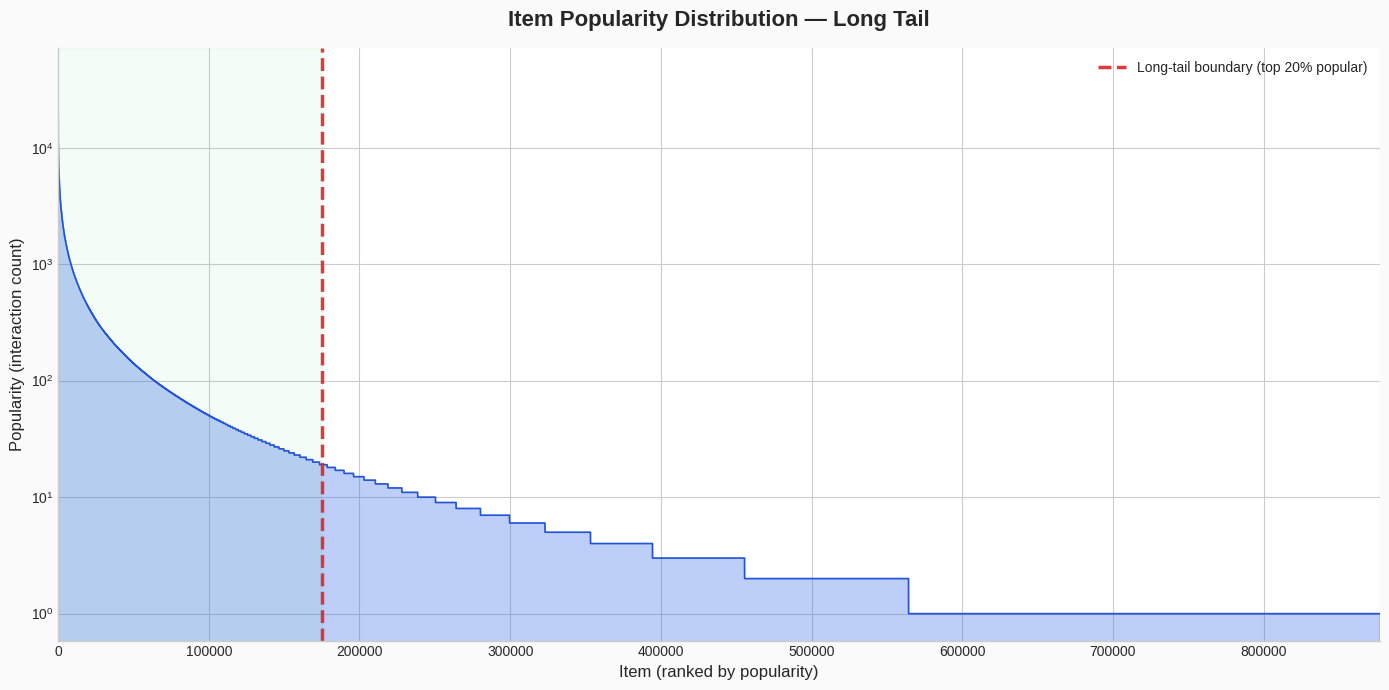

In [10]:
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(14, 7), facecolor="#fafafa")
ax.set_facecolor("#ffffff")

ranks = popularity["rank"].to_numpy()
pops = popularity["popularity"].to_numpy()
n_items = len(popularity)

ax.fill_between(ranks, pops, alpha=0.3, color="#2563eb")
ax.plot(ranks, pops, color="#1d4ed8", linewidth=1.2, alpha=0.95)

split_idx = int(0.2 * n_items)
ax.axvline(x=split_idx, color="#dc2626", linestyle="--", linewidth=2.5,
           label=f"Long-tail boundary (top 20% popular)", alpha=0.9)
ax.axvspan(0, split_idx, alpha=0.05, color="#22c55e")

ax.set_xlabel("Item (ranked by popularity)", fontsize=12, fontweight="500")
ax.set_ylabel("Popularity (interaction count)", fontsize=12, fontweight="500")
ax.set_title("Item Popularity Distribution — Long Tail", fontsize=16, fontweight="600", pad=16)
ax.legend(loc="upper right", framealpha=0.95, fontsize=10)
ax.set_yscale("log")
ax.set_xlim(0, n_items)
ax.tick_params(axis="both", labelsize=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

## Matrix Factorization

The model predicts user-track interaction. Dot product of embeddings is used as logit for sigmoid. For training, we sample random negatives and minimize BCE loss.

In [12]:
uids = df_listens["uid"].unique().sort()
iids = df_listens["item_id"].unique().sort()
uid2idx = {u: i for i, u in enumerate(uids.to_list())}
iid2idx = {i: j for j, i in enumerate(iids.to_list())}
n_users = len(uid2idx)
n_items = len(iid2idx)
print(f"Mapped users: {n_users:,}, items: {n_items:,}")

Mapped users: 9,238, items: 877,168


In [13]:
class MatrixFactorization(nn.Module):
    """Dot product similarity as logit for sigmoid. Learnable scale on dot product."""
    def __init__(self, n_users, n_items, dim=64):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, dim)
        self.item_emb = nn.Embedding(n_items, dim)
        self.scale = nn.Parameter(torch.ones(1))  # learnable scale for dot product
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)

    def forward(self, user_idx, item_idx):
        u = self.user_emb(user_idx)  # (B, dim)
        i = self.item_emb(item_idx)  # (B, dim)
        u = torch.nn.functional.normalize(u, dim=-1)  # L2 normalize
        i = torch.nn.functional.normalize(i, dim=-1)  # L2 normalize
        return self.scale * (u * i).sum(dim=1)  # scaled dot product = cosine similarity, (B,)

In [14]:
class InteractionDataset(Dataset):
    """Positive pairs; negatives sampled on-the-fly."""
    def __init__(self, pairs, n_items, user_items):
        self.pairs = pairs  # list of (user_idx, item_idx)
        self.n_items = n_items
        self.user_items = user_items  # dict user_idx -> set of item_idx

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        u, i_pos = self.pairs[idx]
        i_neg = torch.randint(0, self.n_items, (1,)).item()
        while i_neg in self.user_items.get(u, set()):
            i_neg = torch.randint(0, self.n_items, (1,)).item()
        return u, i_pos, i_neg

In [15]:
def temporal_split(interactions, val_ratio=0.2):
    """Split by timestamp: last val_ratio of time -> validation."""
    df = pl.DataFrame(interactions, schema=["user_idx", "item_idx", "ts"], orient="row").sort("ts")
    thresh = df["ts"].quantile(1 - val_ratio)
    train_df = df.filter(pl.col("ts") < thresh)
    val_df = df.filter(pl.col("ts") >= thresh)
    train = list(zip(train_df["user_idx"].to_list(), train_df["item_idx"].to_list()))
    val = list(zip(val_df["user_idx"].to_list(), val_df["item_idx"].to_list()))
    return train, val

In [16]:
def build_user_items(pairs):
    d = defaultdict(set)
    for u, i in pairs:
        d[u].add(i)
    return d

def recall_at_k(model, val_pairs, user_items_train, n_items, k=10, n_neg=100, device="cpu"):
    """Recall@k: for each (u, i_pos), rank among i_pos + 100 random negatives."""
    model.eval()
    recalls = []
    with torch.no_grad():
        for u, i_pos in val_pairs:
            u_t = torch.tensor([u], device=device, dtype=torch.long)
            # Sample 100 negatives (not in user's train history)
            seen = user_items_train.get(u, set())
            negs = []
            while len(negs) < n_neg:
                cand = np.random.randint(0, n_items)
                if cand not in seen and cand != i_pos:
                    negs.append(cand)
            candidates = [i_pos] + negs
            i_t = torch.tensor(candidates, device=device, dtype=torch.long)
            u_exp = u_t.expand(len(candidates))
            scores = model(u_exp, i_t).cpu().numpy()
            rank = 1 + (scores[1:] > scores[0]).sum()  # 1-indexed rank of positive
            recalls.append(1.0 if rank <= k else 0.0)
    return np.mean(recalls)

In [17]:
def train_mf(train_pairs, val_pairs, n_users, n_items, dim=64, epochs=10, lr=1e-2, batch=4096, device="cpu"):
    user_items = defaultdict(set)
    for u, i in train_pairs:
        user_items[u].add(i)

    ds = InteractionDataset(train_pairs, n_items, user_items)
    loader = DataLoader(ds, batch_size=batch, shuffle=True, num_workers=0)
    model = MatrixFactorization(n_users, n_items, dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    bce = nn.BCEWithLogitsLoss()

    for ep in range(epochs):
        model.train()
        for u, i_pos, i_neg in loader:
            u, i_pos, i_neg = u.to(device), i_pos.to(device), i_neg.to(device)
            opt.zero_grad()
            logit_pos = model(u, i_pos)
            logit_neg = model(u, i_neg)
            loss = (bce(logit_pos, torch.ones_like(logit_pos)) + bce(logit_neg, torch.zeros_like(logit_neg))) / 2
            loss.backward()
            opt.step()
        rec = recall_at_k(model, val_pairs, user_items, n_items, k=10, n_neg=100, device=device)
        print(f"Epoch {ep+1}/{epochs}  Recall@10 = {rec:.4f}")
    return model

In [18]:
uid_df = pl.DataFrame({"uid": list(uid2idx.keys()), "user_idx": list(uid2idx.values())})
iid_df = pl.DataFrame({"item_id": list(iid2idx.keys()), "item_idx": list(iid2idx.values())})
df_mapped = df_listens.join(uid_df, on="uid").join(iid_df, on="item_id")
interactions = list(zip(
    df_mapped["user_idx"].to_list(),
    df_mapped["item_idx"].to_list(),
    df_mapped["timestamp"].to_list(),
))
print(f"Total interactions: {len(interactions):,}")

Total interactions: 46,467,212


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Training and Evaluation

Recall@10 with 100 random negatives: for each (user, item) pair, we rank the positive among 100 negatives and check if it's in top-10.

In [20]:
SUBSAMPLE = 500_000
if SUBSAMPLE:
    rng = np.random.default_rng(42)
    idx = rng.choice(len(interactions), min(SUBSAMPLE, len(interactions)), replace=False)
    interactions = [interactions[i] for i in idx]
    print(f"Subsampled to {len(interactions):,} interactions")

Subsampled to 500,000 interactions


In [22]:
print("=" * 50)
print("Temporal split: last 20% of time = validation")
print("=" * 50)
train_tmp, val_tmp = temporal_split(interactions, val_ratio=0.2)
train_users = {u for u, _ in train_tmp}
val_tmp = [(u, i) for u, i in val_tmp if u in train_users]
print(f"Train: {len(train_tmp):,}, Val: {len(val_tmp):,}")

model_tmp = train_mf(train_tmp, val_tmp, n_users, n_items, dim=64, epochs=5, lr=1e-2, batch=4096, device=device)

user_items_train = build_user_items(train_tmp)

user_interaction_count = {u: len(items) for u, items in user_items_train.items()}

COLD_THRESHOLD = 5

val_cold = [(u, i) for u, i in val_tmp if user_interaction_count.get(u, 0) <= COLD_THRESHOLD]
val_hot = [(u, i) for u, i in val_tmp if user_interaction_count.get(u, 0) > COLD_THRESHOLD]

print(f"\nValidation: {len(val_tmp):,} pairs")
print(f"  Cold users (<= {COLD_THRESHOLD} interactions): {len(val_cold):,} pairs")
print(f"  Hot users (> {COLD_THRESHOLD} interactions): {len(val_hot):,} pairs")

rec_10_all = recall_at_k(model_tmp, val_tmp, user_items_train, n_items, k=10, n_neg=100, device=device)
rec_10_cold = recall_at_k(model_tmp, val_cold, user_items_train, n_items, k=10, n_neg=100, device=device) if val_cold else 0.0
rec_10_hot = recall_at_k(model_tmp, val_hot, user_items_train, n_items, k=10, n_neg=100, device=device) if val_hot else 0.0

print(f"\n=== Results (100 random negatives) ===")
print(f"{'Slice':<25} {'Recall@10':>10}")
print("-" * 36)
print(f"{'All users':<25} {rec_10_all:>10.4f}")
print(f"{'Cold (<=' + str(COLD_THRESHOLD) + ')':<25} {rec_10_cold:>10.4f}")
print(f"{'Hot (>' + str(COLD_THRESHOLD) + ')':<25} {rec_10_hot:>10.4f}")

Temporal split: last 20% of time = validation
Train: 399,999, Val: 93,096
Epoch 1/5  Recall@10 = 0.1610
Epoch 2/5  Recall@10 = 0.5502
Epoch 3/5  Recall@10 = 0.6576
Epoch 4/5  Recall@10 = 0.6733
Epoch 5/5  Recall@10 = 0.6786

Validation: 93,096 pairs
  Cold users (<= 5 interactions): 5,338 pairs
  Hot users (> 5 interactions): 87,758 pairs

=== Results (100 random negatives) ===
Slice                      Recall@10
------------------------------------
All users                     0.6792
Cold (<=5)                    0.6525
Hot (>5)                      0.6806
